<center>
    <img src="https://www.ucalgary.ca/themes/ucalgary/ucws_theme/images/UCalgary.svg" width='30%'>
</center>

[comment]: <> (The following line is for the TOPIC of the week)
<p style="text-align:left;"><font size='4'><b> Introduction to NLP </b></font></p>

---


# Machine Learning in NLP

Most ML model development cycle can be done in five steps:
1. Get the data
2. Feature Engineering
3. Choose and Train a ML/DL model
4. Validate the model
5. Deploy the model

For NLP+ML, all steps can be the same except Feature Engineering -- How to represent the text data.




## Example use case -- text classification

### movie review
IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.
For more dataset information, please go through the following link,
http://ai.stanford.edu/~amaas/data/sentiment/

In [23]:
# load movie review dataset
import os
if not os.path.exists('aclImdb'):
    !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    !tar -zxvf aclImdb_v1.tar.gz

In [24]:
with open('aclImdb/train/pos/0_9.txt') as f:
    print(f.read())

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


# Data Representation in NLP for ML

Unlike human, computers can not understand language directly. For most machine learning models, features can be represented by numbers directly. However, text are a sequence of characters which can not be processed by machine learning model directly. Therefore, we need to convert the text data into a way that model can understand -- vectors.

## Binary representation

The most straightforward way is to assign a unique number to each token in the corpus. Then each token can be represneted by a one-hot vector where the dimension of the vector is the size of the vocabulary, 1 indicate the index of the token in the vocabulary and 0 for other indexes.

In [25]:
docs = [
    "this is an example sentence",
    "another sentence is here"
]

def preprocess(text):
    """
    break a sentence into a list of tokens.
    """
    #char-based model
    tokens = text.split()
    return tokens

def build_vocabulary(docs):
    """
    map the token to an unique idx
    """
    # build vocabulary
    # vocabulary that maps each token to a unique id
    word2idx = {}
    # revert map from uid to token
    idx2word = []

    for sentence in docs:
        for token in sentence:
            if token not in word2idx:
                word2idx[token] = len(word2idx)
                idx2word.append(token)
    return word2idx, idx2word

In [26]:
# convert text to feature vectors
def vectorize(docs):
    docs = [preprocess(text) for text in docs]

    word2idx, idx2word = build_vocabulary(docs)
    print(word2idx)
    print(idx2word)

    for tokens in docs:
        # feature = [0,0,0,0,...,0]
        feature = [0 for _ in range(len(word2idx))]
        for token in tokens:
            # ignore out of vocabulary token
            if token not in word2idx:
                continue
            feature[word2idx[token]] = 1
        yield feature

for doc, feature in zip(docs, vectorize(docs)):
    print('=' * 20)
    print(doc)
    print(feature)

{'this': 0, 'is': 1, 'an': 2, 'example': 3, 'sentence': 4, 'another': 5, 'here': 6}
['this', 'is', 'an', 'example', 'sentence', 'another', 'here']
this is an example sentence
[1, 1, 1, 1, 1, 0, 0]
another sentence is here
[0, 1, 0, 0, 1, 1, 1]


Let's work on a real dataset

In [27]:
# read dataset
from pathlib import Path

dataset_path = Path('./aclImdb/')

LIMIT = 200

train_docs = []
train_label = []
for fid, file in enumerate(dataset_path.glob('train/pos/*.txt')):
    if fid >= LIMIT:
        break
    with file.open() as f:
        train_docs.append(f.read().strip())
        train_label.append(1)

for fid, file in enumerate(dataset_path.glob('train/neg/*.txt')):
    if fid >= LIMIT:
        break
    with file.open() as f:
        train_docs.append(f.read().strip())
        train_label.append(0)

test_docs = []
test_label = []
for fid, file in enumerate(dataset_path.glob('test/pos/*.txt')):
    if fid >= LIMIT:
        break
    with file.open() as f:
        test_docs.append(f.read().strip())
        test_label.append(1)

for fid, file in enumerate(dataset_path.glob('test/neg/*.txt')):
    if fid >= LIMIT:
        break
    with file.open() as f:
        test_docs.append(f.read().strip())
        test_label.append(0)
len(train_docs), len(train_label), len(test_docs), len(test_label)

(400, 400, 400, 400)

In [28]:
# we will use this later
def featurize(docs):
    docs = [preprocess(text) for text in docs]

    word2idx, idx2word = build_vocabulary(docs)

    features = []
    for tokens in docs:
        feature = [0 for _ in range(len(word2idx))]
        for token in tokens:
            # ignore out of vocabulary token
            if token not in word2idx:
                continue
            feature[word2idx[token]] = 1
        features.append(feature)
    return features

We're going to use a Naive Bayes classifier to do document classification.

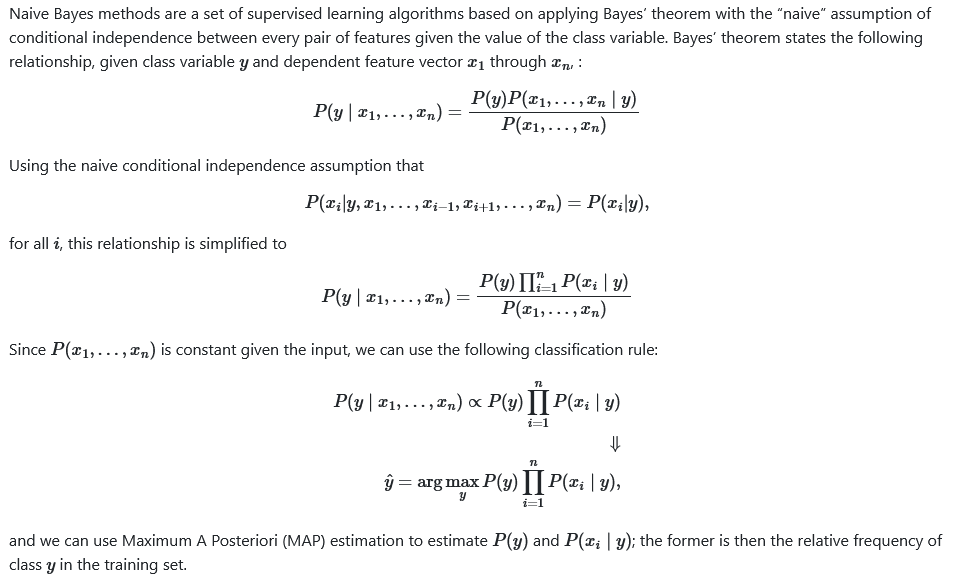

In [29]:
# train a Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB as NB
from sklearn.metrics import classification_report


clf = NB()

features = featurize(train_docs+test_docs)
train_features = features[:len(train_docs)]
test_features = features[-len(test_docs):]

clf.fit(train_features, train_label)

test_prediction = clf.predict(test_features)

report = classification_report(test_label, test_prediction, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.6406    0.9000    0.7484       200
           1     0.8319    0.4950    0.6207       200

    accuracy                         0.6975       400
   macro avg     0.7363    0.6975    0.6846       400
weighted avg     0.7363    0.6975    0.6846       400



In [30]:
sentence1 = 'this movie is realy good' # -> [1,1,1,1,1]
sentence2 = 'this movie is realy realy good' # -> [1,1,1,2,1]

## Word Count representation

Binary representation gives a good illustration of how to represent text for Machine learning. However, it does not consider the occurrency of a word. Then, it is common to see people introduce count of a word in the feature vector.

In [31]:
# convert text to feature vectors
def featurize(docs):
    docs = [preprocess(text) for text in docs]

    word2idx, idx2word = build_vocabulary(docs)

    features = []
    for tokens in docs:
        feature = [0 for _ in range(len(word2idx))]
        for token in tokens:
            # ignore out of vocabulary token
            if token not in word2idx:
                continue
            feature[word2idx[token]] += 1
        features.append(feature)
    return features

In [32]:
clf = NB()

features = featurize(train_docs+test_docs)
train_features = features[:len(train_docs)]
test_features = features[-len(test_docs):]

clf.fit(train_features, train_label)
test_prediction = clf.predict(test_features)
report = classification_report(test_label, test_prediction, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.6360    0.9000    0.7453       200
           1     0.8291    0.4850    0.6120       200

    accuracy                         0.6925       400
   macro avg     0.7326    0.6925    0.6787       400
weighted avg     0.7326    0.6925    0.6787       400



Looks like word count in a sample does not boost the accuarcy, but why?

Word count capture the local frequency of a word in a sample. Is higher word count means more information? Not necessarily.
In Movie Reivew dataset, `movie` can be a very high frequent word, therefore the word count for `movie` in each document is also high. However, it is not a good indicator that a sample is positive or negative. Therefore, we need a global information to help here.



### Term Frequency - Inverse Document Frequency (TF-IDF)

As the name suggested, TF-IDF contains two parts -- Term Frequency and Document Frequency.

#### Term Frequency
The weight of a term that occurs in a document is simply proportional to the term frequency.

$\mathrm {tf} (t,d)={\frac {f_{t,d}}{\sum _{t'\in d}{f_{t',d}}}} = {\frac {f_{t,d}}{len(d)}}$

where $f_{t,d}$ is the count of a term $t$ in a document $d$.

#### Document Frequency

The inverse document frequency is a measure of how much information the word provides.

$\mathrm{idf}(t, D) =  \log \frac{N}{|\{d \in D: t \in d\}|}$

where $N$ is total number of documents in the corpus, $|\{d \in D: t \in d\}|$ represent the total number of document that contain token $t$.

Note that $|\{d \in D: t \in d\}|$ could be zero if term not in the corpus (during the inference for example), then it is common to see smooth-one adjustment with $1 + |\{d \in D: t \in d\}|$.


In [33]:
# let's code it out.
from collections import Counter
import math

def get_document_frequency(docs, word2idx):
    document_frequency = Counter()
    for tokens in docs:
        for token in set(tokens):
            if token not in word2idx:
                continue
            document_frequency[word2idx[token]] += 1

    return document_frequency

def tf_idf(tokens, word2idx, document_frequency, total_documents):
    feature = [0 for _ in range(len(word2idx))]
    for token in tokens:
        if token not in word2idx:
            continue
        token_idx = word2idx[token]
        feature[token_idx] += 1/len(tokens) * math.log((total_documents+1) / (document_frequency[token_idx]+1))
    return feature

def featurize(docs):
    docs = [preprocess(text) for text in docs]

    word2idx, idx2word = build_vocabulary(docs)
    print(len(word2idx))
    document_frequency = get_document_frequency(docs, word2idx)

    features = []
    for tokens in docs:
        features.append(tf_idf(tokens, word2idx, document_frequency, len(docs)))
    return features

In [34]:
clf = NB()

features = featurize(train_docs+test_docs)
train_features = features[:len(train_docs)]
test_features = features[-len(test_docs):]

clf.fit(train_features, train_label)
test_prediction = clf.predict(test_features)
report = classification_report(test_label, test_prediction, digits=4)
print(report)

29049
              precision    recall  f1-score   support

           0     0.6667    0.9100    0.7696       200
           1     0.8583    0.5450    0.6667       200

    accuracy                         0.7275       400
   macro avg     0.7625    0.7275    0.7181       400
weighted avg     0.7625    0.7275    0.7181       400



In [35]:
sum(1 for x in features[-1] if x == 0), len(features[-1])

(28631, 29049)

# pre-processing

## Curse of dimensionality

1. speed
2. less training data per feature

Example above generate feature vector with dimension of 88k on only 2k documents. On a larger dataset, it can go easily above 3M.

Therefore, pre-process on text is needed for NLP + ML.

## lower-case

Most tokens (not all of them) can be lower cased without loosing the information.

In [36]:
def preprocess(text):
    text = text.lower()
    tokens = text.split()
    return tokens

## Tokenization

Tkenization splits a phrase, sentence, paragraph, or an entire text document into a smaller units, such as individual words or terms. Each of these smaller units is called token.

If you notice the example above, we use `str.split()` method to get the individual token. It works if the words is seperated by space, but won't work if there is a puncuation in between.

In [37]:
text = 'The cat sit on the mat. "cat" , $100.00 '
text.split()

['The', 'cat', 'sit', 'on', 'the', 'mat.', '"cat"', ',', '$100.00']

Therefore, we need a more advanced tokenizer to remove the puncuation.

In [38]:
import re
PATTERN = r"\w+"
tokenizer = re.compile(PATTERN)

def preprocess(text):
    text = text.lower()
    tokens = tokenizer.findall(text)
    return tokens

preprocess(text)

['the', 'cat', 'sit', 'on', 'the', 'mat', 'cat', '100', '00']

In [39]:
# nltk.wordtokenizer

Common patterns:

- basic: `r"\w+"`
- white space: `r"\s+"`
- word puncuation: `r"\w+|[^\w\s]+"`
- sklearn default: `r"(?u)\b\w\w+\b"`

## stop words


### what is stop words?
A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that provides less information in a sentence.

In [40]:
# download nltk stopwords list
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

STOP_WORDS = set(stopwords.words('english'))

STOP_WORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [41]:
def preprocess(text):
    text = text.lower()
    tokens = tokenizer.findall(text)
    tokens = [token for token in tokens if token not in STOP_WORDS]
    return tokens

In [42]:
features = featurize(train_docs+test_docs)

15688


In [43]:
clf = NB()

features = featurize(train_docs+test_docs)
train_features = features[:len(train_docs)]
test_features = features[-len(test_docs):]

clf.fit(train_features, train_label)
test_prediction = clf.predict(test_features)
report = classification_report(test_label, test_prediction, digits=4)
print(report)

15688
              precision    recall  f1-score   support

           0     0.7377    0.9000    0.8108       200
           1     0.8718    0.6800    0.7640       200

    accuracy                         0.7900       400
   macro avg     0.8047    0.7900    0.7874       400
weighted avg     0.8047    0.7900    0.7874       400



### bag-of-words and n-grams

If you notice the code above, each dimension of the feature represent a single word. Then each sentence/document can be represented by a vector with 0 and the tf-idf of its words. Yet the order of those tokens are not represented. e.g.

`The white dog is chasing the black cat` and `The cat is chasing the black white dog` will have the same feature vector. It is like we throw the words in to bags where each bag represents a word. And we can use the number of words in all bags to represent the sentence. Therefore, this technique is also known as bag-of-words.

### how to reseve the order of the words

Just like the example above, bag-of-words on single words does not preseve the order information of the words. In reality, people will use longer than one word to in their language to represent something. e.g. `apple tree`. Then we can create token with multiple words together to capture more information. We call this method n-grams.

In `n-grams`, `n` represent the number of the token in the gram.
- `n = 1`, uni-gram
- `n = 2`, bi-gram
- `n = 3`, tri-gram, or 3-gram

In practice, `n=3` is the largest setting we use.

In [44]:
# "a b c d" => "a" "b" "c" "d" -> uni-gram
# "a b c d" => "a b" "b c" "c d" -> bigram
# "a b c d" => "a b c" "b c d" -> trigram

In [45]:
def preprocess(text):
    text = text.lower()
    tokens = tokenizer.findall(text)
    tokens = [token for token in tokens if token not in STOP_WORDS]
    # bigram
    tokens += list(zip(tokens[:-1], tokens[1:]))
    return tokens

preprocess('The white dogs are chasing the black cat')

['white',
 'dogs',
 'chasing',
 'black',
 'cat',
 ('white', 'dogs'),
 ('dogs', 'chasing'),
 ('chasing', 'black'),
 ('black', 'cat')]

## stemming

Stemming is an NLP technique that lowers inflection in words to their root forms. e.g.

- `dogs` -> `dog`
- `interesting` -> `interest`

In [46]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

[stemmer.stem(x) for x in ['dogs', 'interesting', 'acquisition', 'acquire', 'acquires']]

['dog', 'interest', 'acquisit', 'acquir', 'acquir']

In [47]:
from nltk.util import everygrams
def preprocess(text):
    text = text.lower()
    tokens = tokenizer.findall(text)
    tokens = [token for token in tokens if token not in STOP_WORDS]
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = list(everygrams(tokens,min_len=1, max_len=3))
    # tokens += list(zip(tokens[:-1], tokens[1:]))
    return tokens

preprocess('The white dog is chasing the black cat')

[('white',),
 ('white', 'dog'),
 ('white', 'dog', 'chase'),
 ('dog',),
 ('dog', 'chase'),
 ('dog', 'chase', 'black'),
 ('chase',),
 ('chase', 'black'),
 ('chase', 'black', 'cat'),
 ('black',),
 ('black', 'cat'),
 ('cat',)]

In [48]:
clf = NB()

features = featurize(train_docs+test_docs)
train_features = features[:len(train_docs)]
test_features = features[-len(test_docs):]

clf.fit(train_features, train_label)
test_prediction = clf.predict(test_features)
report = classification_report(test_label, test_prediction, digits=4)
print(report)

179477
              precision    recall  f1-score   support

           0     0.7532    0.8850    0.8138       200
           1     0.8606    0.7100    0.7781       200

    accuracy                         0.7975       400
   macro avg     0.8069    0.7975    0.7959       400
weighted avg     0.8069    0.7975    0.7959       400



In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [50]:
# without any preprocessing
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
train_features = vectorizer.fit_transform(train_docs)

test_features = vectorizer.transform(test_docs)
train_features.shape

(400, 47665)

In [51]:
clf = NB()

clf.fit(train_features, train_label)

test_prediction = clf.predict(test_features)

report = classification_report(test_label, test_prediction, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.7132    0.9450    0.8129       200
           1     0.9185    0.6200    0.7403       200

    accuracy                         0.7825       400
   macro avg     0.8159    0.7825    0.7766       400
weighted avg     0.8159    0.7825    0.7766       400

